Action space size:  2
State space size:  4
states high value:
4.8
3.4028235e+38
0.41887903
3.4028235e+38
states low value:
-4.8
-3.4028235e+38
-0.41887903
-3.4028235e+38
(1, 1, 6, 12, 2)
[[[[[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]
    [0. 0.]

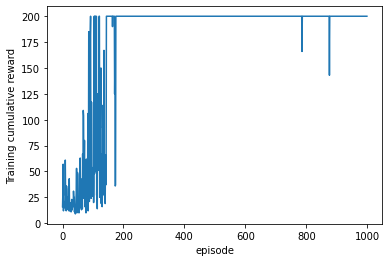

[[[[[0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]]

   [[4.41836863e+01 4.98197405e+01]
    [3.00238948e+01 4.59838552e+01]
    [1.47023860e+01 4.75809100e+01]
    [2.88784149e+01 4.38313070e+01]
    [1.26059291e+01 3.75362692e+01]
    [3.85761877e+00 3.29890833e+01]
    [5.12505962e+00 1.07641150e+01]
    [0.00000000e+00 1.85685994e+01]
    [0.00000000e+00 6.52195118e+01]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]
    [0.00000000e+00 0.00000000e+00]]

   [[1.76450525e+03 9.75379750e+02]
    [1.84620858e+03 1.25493957e+03]
    [1.83857410e+03 1.08731089e+03]
    [1.87100131e+03 1.77

In [4]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

# CREATE ENVIRONMENT
env = gym.make('CartPole-v1')
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]
print("Action space size: ", n_actions)
print("State space size: ", n_states)

print('states high value:')
print(env.observation_space.high[0])
print(env.observation_space.high[1])
print(env.observation_space.high[2])
print(env.observation_space.high[3])

print('states low value:')
print(env.observation_space.low[0])
print(env.observation_space.low[1])
print(env.observation_space.low[2])
print(env.observation_space.low[3])
# define the number of buckets for each state value (x, x', theta, theta')
buckets = (1, 1, 6, 12)

# define upper and lower bounds for each state value
upper_bounds = [
        env.observation_space.high[0],
        0.5,
        env.observation_space.high[2],
        math.radians(50)
        ]
lower_bounds = [
        env.observation_space.low[0],
        -0.5,
        env.observation_space.low[2],
        -math.radians(50)]

# HYPERPARAMETERS
n_episodes = 1000      # Total train episodes
n_steps = 200               # Max steps per episode
min_alpha = 0.1             # learning rate
min_epsilon = 0.1           # exploration rate
gamma = 1.0                 # discount factor
ada_divisor = 25            # decay rate parameter for alpha and epsilon

# INITIALISE Q MATRIX
Q = np.zeros(buckets + (n_actions,))
print(np.shape(Q))#shape of the matrix
print(Q)
def discretize(obs):
    ''' discretise the continuous state into buckets '''
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

def epsilon_policy(state, epsilon):
    ''' choose an action using the epsilon policy '''
    exploration_exploitation_tradeoff = np.random.random()
    if exploration_exploitation_tradeoff <= epsilon:
        action = env.action_space.sample()  # exploration
    else:
        action = np.argmax(Q[state])   # exploitation
    return action

def greedy_policy(state):
    ''' choose an action using the greedy policy '''
    return np.argmax(Q[state])

def update_q(current_state, action, reward, new_state, alpha):
    ''' update the Q matrix with the Bellman equation '''
    Q[current_state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[current_state][action])

def get_epsilon(t):
    ''' decrease the exploration rate at each episode '''
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / ada_divisor)))

def get_alpha(t):
    ''' decrease the learning rate at each episode '''
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / ada_divisor)))


# TRAINING PHASE
rewards = []

for episode in range(n_episodes):
    current_state = env.reset()
    current_state = discretize(current_state)

    alpha = get_alpha(episode)
    epsilon = get_epsilon(episode)

    episode_rewards = 0

    for t in range(n_steps):

        action = epsilon_policy(current_state, epsilon)
        new_state, reward, done, _ = env.step(action)
        new_state = discretize(new_state)
        update_q(current_state, action, reward, new_state, alpha)
        current_state = new_state
        # at the end of the episode
        if done:
            print('Episode:{}/{} finished with a total reward of: {}'.format(episode, n_episodes, episode_rewards))
            break
        # increment the cumulative reward
        episode_rewards += reward



    # append the episode cumulative reward to the reward list
    rewards.append(episode_rewards)

# PLOT RESULTS
x = range(n_episodes)
plt.plot(x, rewards)
plt.xlabel('episode')
plt.ylabel('Training cumulative reward')
plt.show()
print(Q)

# TEST PHASE
current_state = env.reset()
current_state = discretize(current_state)
print(current_state)
episode_rewards = 0



env.close()